In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
import random
import copy
import ast
import pprint
import json
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

In [17]:
def set_seed():
    random.seed(0)
    np.random.seed(0)

In [18]:
DATA_DIR = Path('data/')

## Examples

In [4]:
df = pd.read_csv(DATA_DIR / 'datasets/merged/val_0.csv')

In [5]:
df.head()

,id,device,location,number,device_name,device_id,env,user_cmd,mtd,json_cmd,methods_descr,methods_names
0,0,Light,Study room,1,Study room Light 1,98,"Light, name=""Study room Light 1"", id=98;\nTemp...",Turn on the Study room Light 1.,Light.Toggle,"{""method"": ""Light.Toggle"", ""params"": {""id"": 98}}",API method 0:\nMethod name: Light.Set\nMethod ...,"Light.Set,Light.GetConfig,Light.Toggle"
1,1,Light,Outdoor,4,Outdoor Light 4,75,"Light, name=""Kitchen Light 2"", id=13;\nLight, ...",Turn on the Outdoor Light 4.,Light.Toggle,"{""method"": ""Light.Toggle"", ""params"": {""id"": 75}}",API method 0:\nMethod name: Light.Set\nMethod ...,"Light.Set,Light.GetConfig,Light.Toggle"
2,2,Light,Bedroom,1,Bedroom Light 1,88,"Cover, name=""Garage Cover 1"", id=56;\nLight, n...",Turn on the Bedroom Light 1.,Light.Toggle,"{""method"": ""Light.Toggle"", ""params"": {""id"": 88}}",API method 0:\nMethod name: Light.SetConfig\nM...,"Light.SetConfig,Light.Set,Light.Toggle"
3,3,Light,Attic,3,Attic Light 3,62,"Cover, name=""Office Cover 4"", id=94;\nInput, n...",Turn on the Attic Light 3.,Light.Toggle,"{""method"": ""Light.Toggle"", ""params"": {""id"": 62}}",API method 0:\nMethod name: Light.Set\nMethod ...,"Light.Set,Light.SetConfig,Light.Toggle"
4,4,Light,Outdoor,3,Outdoor Light 3,32,"Smoke, name=""Basement Smoke 2"", id=92;\nLight,...",Turn on the Outdoor Light 3.,Light.Toggle,"{""method"": ""Light.Toggle"", ""params"": {""id"": 32}}",API method 0:\nMethod name: Light.Set\nMethod ...,"Light.Set,Light.SetConfig,Light.Toggle"


In [20]:
def get_prompt_template():
    prompt_template = """{instruction}
{json_scheme}

Devices: {env}
Methods:
{methods_description}

Command: {user_cmd}
JSON:
    """

    return prompt_template

print(get_prompt_template())

{instruction}
{json_scheme}

Devices: {env}
Methods:
{methods_description}

Command: {user_cmd}
JSON:
    


In [21]:
def get_prompts_df(df):
    with open(DATA_DIR / 'prompts/validation/components/instruction.md') as f:
        instruction = f.read()
    json_scheme_prompt = {
            "method": {
                "type": "string"
            },
            "params": {
                "type": "object"
            }
        }
    json_scheme = "The output JSON should follow the next scheme: " + json.dumps(json_scheme_prompt)

    prompts_df = pd.DataFrame(columns=['user', 'assistant'])

    for i, row in df.iterrows():
        # print(i)
        user_cmd = row['user_cmd']
        env = row['env']
        methods_description = row['methods_descr']

        user_prompt = get_prompt_template().format(**{'instruction': instruction,
                                                    'json_scheme': json_scheme,
                                                    'env': env,
                                                    'methods_description': methods_description, 
                                                    'user_cmd': user_cmd})

        series = pd.Series({'user': user_prompt, 'assistant': row['json_cmd']})
        prompts_df.loc[len(prompts_df)] = series
    
    return prompts_df

In [ ]:
prompts_df = get_prompts_df(df)

In [8]:
prompts_df.head()

,user,assistant
0,You are a helpful AI Assistant that controls d...,"{""method"": ""Light.Toggle"", ""params"": {""id"": 98}}"
1,You are a helpful AI Assistant that controls d...,"{""method"": ""Light.Toggle"", ""params"": {""id"": 75}}"
2,You are a helpful AI Assistant that controls d...,"{""method"": ""Light.Toggle"", ""params"": {""id"": 88}}"
3,You are a helpful AI Assistant that controls d...,"{""method"": ""Light.Toggle"", ""params"": {""id"": 62}}"
4,You are a helpful AI Assistant that controls d...,"{""method"": ""Light.Toggle"", ""params"": {""id"": 32}}"


In [10]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

In [11]:
prompts_df['num_tokens'] = 0

for i, row in prompts_df.iterrows():
    ids = tokenizer.apply_chat_template([{'role': 'user', 'content': row['user']}, {'role': 'assistant', 'content': row['assistant']}], return_tensors='np')[0]
    prompts_df.loc[i, 'num_tokens'] = len(ids)

In [59]:
o = tokenizer.apply_chat_template([{'role': 'user', 'content': 'a'}, {'role': 'assistant', 'content': 'b'}], return_tensors='np', tokenize=False)
o

'<s>[INST] a [/INST]b</s>'

In [38]:
tokenizer.pad_token = tokenizer.unk_token
o = tokenizer("abc", max_length=2000, padding='max_length', return_tensors='np', return_attention_mask=True)
print(o)
tokenizer.decode([1, 18641])

{'input_ids': array([[    0,     0,     0, ...,     0,     1, 18641]]), 'attention_mask': array([[0, 0, 0, ..., 0, 1, 1]])}


'<s> abc'

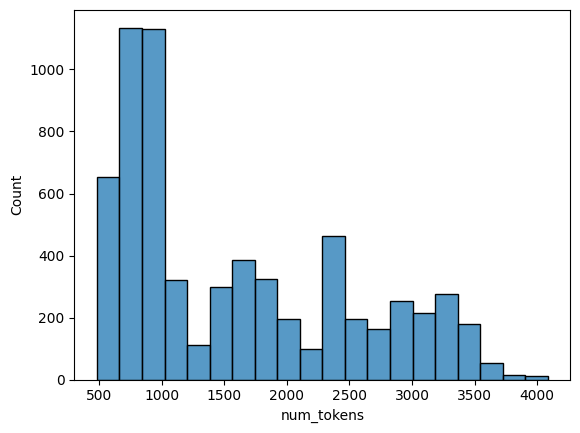

In [12]:
sns.histplot(prompts_df['num_tokens'], bins=20)
plt.show()

In [13]:
max(prompts_df['num_tokens'])

4085

In [14]:
res_df = prompts_df.drop(columns=['num_tokens'])

In [15]:
res_df.to_csv(DATA_DIR / 'datasets/merged/train.csv', index=False)

## Pipeline

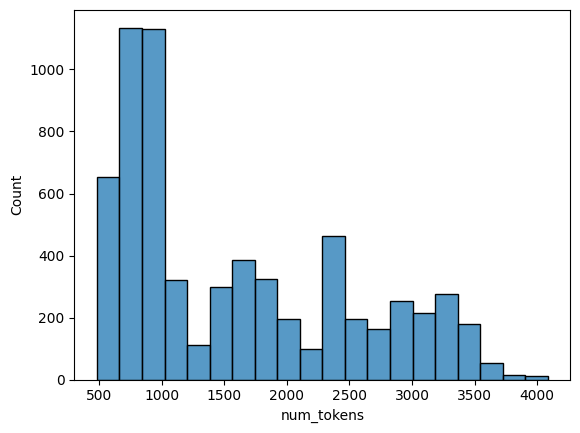

4085.0


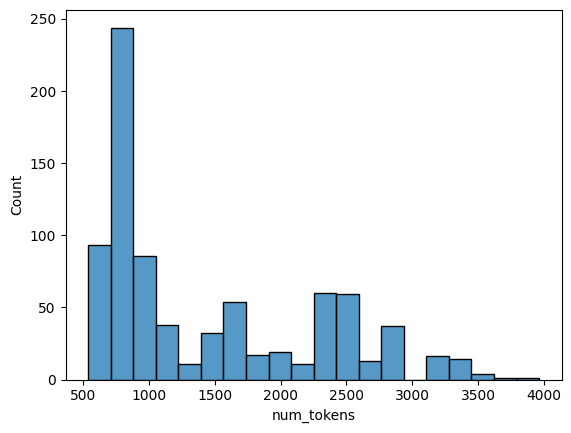

3961.0


In [22]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

for split in ['train', 'val']:
    df = pd.read_csv(DATA_DIR / f'datasets/merged/{split}_0.csv')

    prompts_df = get_prompts_df(df)

    for i, row in prompts_df.iterrows():
        ids = tokenizer.apply_chat_template([{'role': 'user', 'content': row['user']}, {'role': 'assistant', 'content': row['assistant']}], return_tensors='np')[0]
        prompts_df.loc[i, 'num_tokens'] = len(ids)

    sns.histplot(prompts_df['num_tokens'], bins=20)
    plt.show()
    print(max(prompts_df['num_tokens']))
    
    res_df = prompts_df.drop(columns=['num_tokens'])

    res_df.to_csv(DATA_DIR / f'datasets/merged/{split}.csv', index=False)